In [1]:
import pandas as pd
import numpy as np
import joblib as jb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from satellite_bathymetry.preprocessing import get_coord_from_pixel_pos, get_pixel_from_coord, ndwi, pixel_ndwi, pixel_log_ratio

In [232]:
#path = '../data/generated/df_newimages_bands_downside.pkl.z'
path = '../data/generated/df_newimages_bands_downside_low_var_filter.pkl.z'
df = jb.load(path)
df['ndwi51'] =  df[['b5', 'b1']].apply(lambda x: pixel_ndwi(x.b5, x.b1), axis=1)
df.head()

,x,y,z,b1,b2,b3,b4,b5,b6,b7,b8,b2b4,b3b4,ndwi15,ndwi24,ndwi53,cspmb7,ndwi51
0,233,1130,3.195862,0.1199,0.0866,0.0667,0.0464,0.0490,0.0316,0.0283,0.0238,1.162614,1.094573,0.419775,0.302256,-0.152982,23.382784,-0.419775
1,233,1131,3.273030,0.1199,0.0880,0.0668,0.0457,0.0490,0.0316,0.0283,0.0237,1.171434,1.099318,0.419775,0.316380,-0.153713,23.382784,-0.419775
2,233,1132,3.299687,0.1199,0.0879,0.0666,0.0461,0.0488,0.0324,0.0281,0.0238,1.168473,1.096035,0.421458,0.311940,-0.154246,23.158824,-0.421458
3,233,1133,3.268182,0.1199,0.0882,0.0692,0.0452,0.0488,0.0324,0.0281,0.0232,1.175411,1.111754,0.421458,0.322339,-0.172881,23.158824,-0.421458
4,233,1134,3.278125,0.1196,0.0884,0.0677,0.0454,0.0489,0.0323,0.0285,0.0238,1.174645,1.104724,0.419585,0.321375,-0.161235,23.607309,-0.419585


In [233]:
image = np.zeros((df.y.max()+1, df.x.max()+1))

In [234]:
image.shape

(1639, 2297)

In [235]:
for i, row in enumerate(df.itertuples()):
    x = row.x
    y = row.y
    z = row.z
    image[y][x] = z

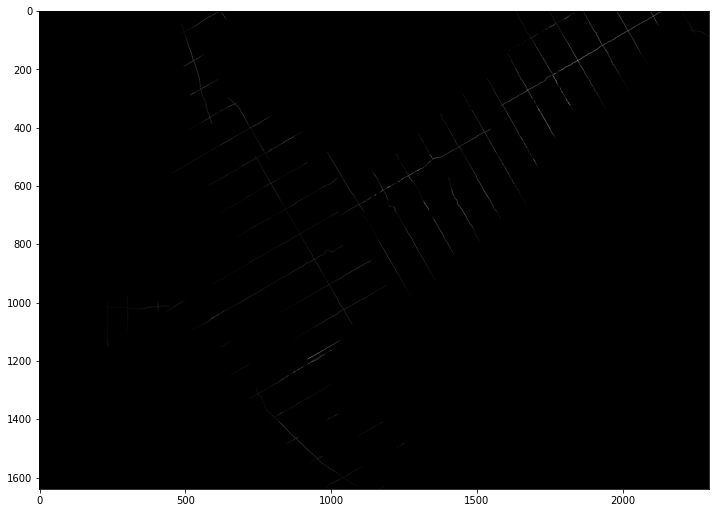

In [236]:
plt.figure(figsize=(12,10))
plt.imshow(image, 'gray')

In [406]:
kernel = np.ones((50,50))

In [407]:
def train_test_window_dataset(image, kernel, df, features_columns, train_window_size=1):
    """
    Apply rolling window defined by kernel on bathymetry image and extract
    train and validation data from pixel position concatenating with dataframe features_columns data
    train_window_size controls how many windows will be applied for extract train data
    e.g:
    train_window_size = 2
    2 kernel size for train
    1 kernel size for val
    the proportion is always 1 val for N train_window_size
    """
    output_train_data = [] # list of dict with data
    output_val_data = [] # list of dict with data
    y_start = 0
    y_end = kernel.shape[0]
    x_end = image.shape[1]
    train_controller = True
    val_controller = False
    
    train_window_counter = 0
    
    while True:
        for row in range(y_start, y_end):
            for column in range(x_end):
                px = column
                py = row
                z = image[py][px]
                if z != 0:
                    df_row = df[(df.x == px) & (df.y == py)]
                    aux_dict = {
                        'index': df_row.index[0],
                        'z': z,
                        'x': px,
                        'y': py,
                    }
                    if train_controller:
                        output_train_data.append(aux_dict)
                    if val_controller:
                        output_val_data.append(aux_dict)
        
        y_start = y_end
        y_end = y_end + kernel.shape[0]
        
        if (train_window_counter == train_window_size) and train_controller:
            # Reverse if on max
            train_controller = not train_controller
            val_controller = not val_controller
            train_window_counter = 0
        elif not train_controller:
            train_controller = not train_controller
            val_controller = not val_controller
        else:
            train_window_counter += 1
        

        if y_end > image.shape[0] and y_end != y_start:
            y_end = image.shape[0]

        if y_start > image.shape[0] or y_end == y_start:
            break

    train_df = pd.DataFrame(output_train_data).set_index('index')
    val_df = val_df = pd.DataFrame(output_val_data).set_index('index')
    
    output_train_df = df[df.index.isin(train_df.index)][features_columns]
    output_val_df = df[df.index.isin(val_df.index)][features_columns]
    
    # Return train and val dataframe with same index as the input dataframe and with selected features
    return output_train_df, output_val_df

In [446]:
features_columns = list(df.columns)
train_df, val_df = train_test_window_dataset(image, kernel, df, features_columns=features_columns, train_window_size=1)

In [409]:
len(train_df), len(val_df)

(12079, 6176)

In [410]:
len(train_df) + len(val_df)

18255

In [411]:
import cv2

rgb_image = cv2.imread('../data/generated/rgb_image.jpg')
#image = rgb_image.copy()
for i, row in enumerate(train_df.itertuples()):
    x = int(row.x)
    y = int(row.y)
    rgb_image = cv2.circle(rgb_image ,(x,y),1,[255,0,0],1)
cv2.imwrite('generated/train_data.jpg', rgb_image)

True

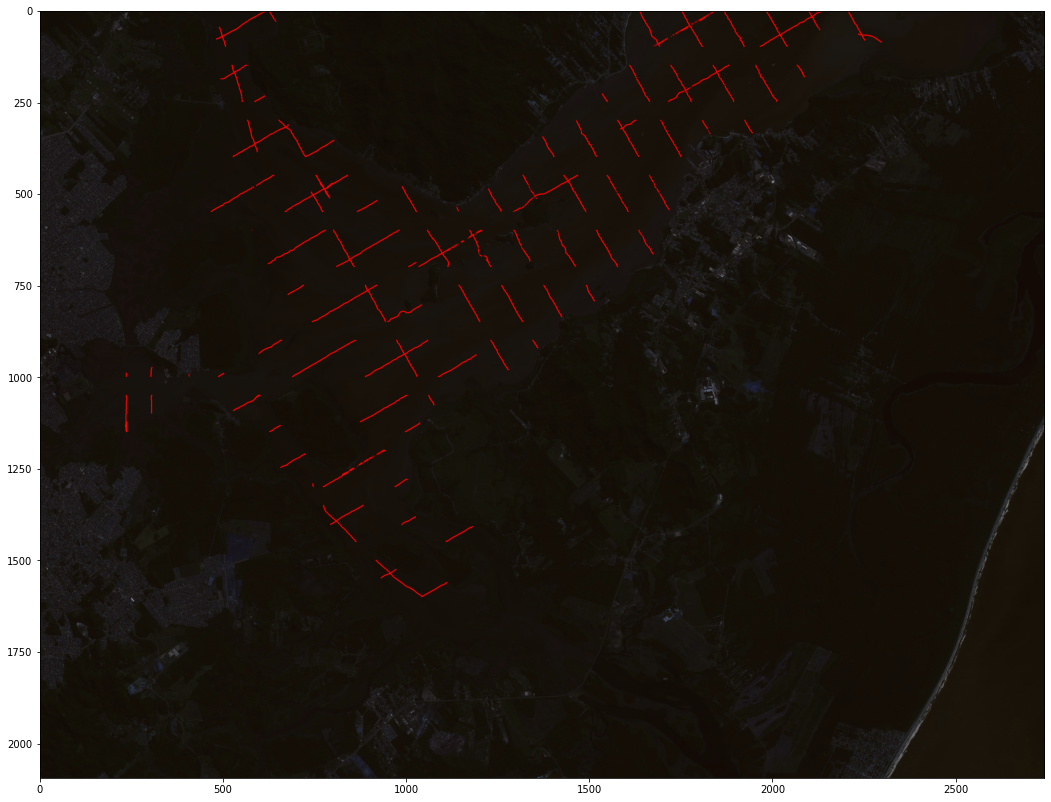

In [412]:
plt.figure(figsize=(18, 15))
plt.imshow(rgb_image)

In [413]:
import cv2

rgb_image = cv2.imread('../data/generated/rgb_image.jpg')
#image = rgb_image.copy()
for i, row in enumerate(val_df.itertuples()):
    x = int(row.x)
    y = int(row.y)
    rgb_image = cv2.circle(rgb_image ,(x,y),1,[255,0,0],1)
cv2.imwrite('generated/val_data.jpg', rgb_image)

True

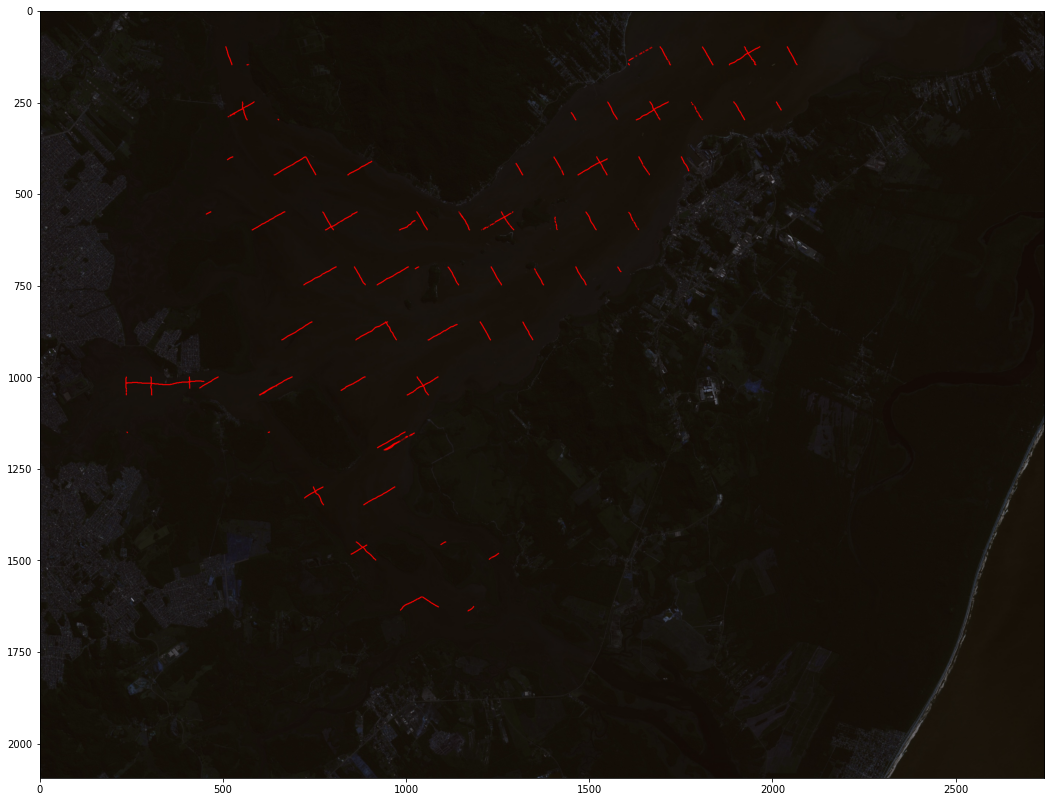

In [414]:
plt.figure(figsize=(18, 15))
plt.imshow(rgb_image)

In [426]:
import seaborn as sns

In [447]:
train = train_df.copy()
val = val_df.copy()

<AxesSubplot:ylabel='z'>

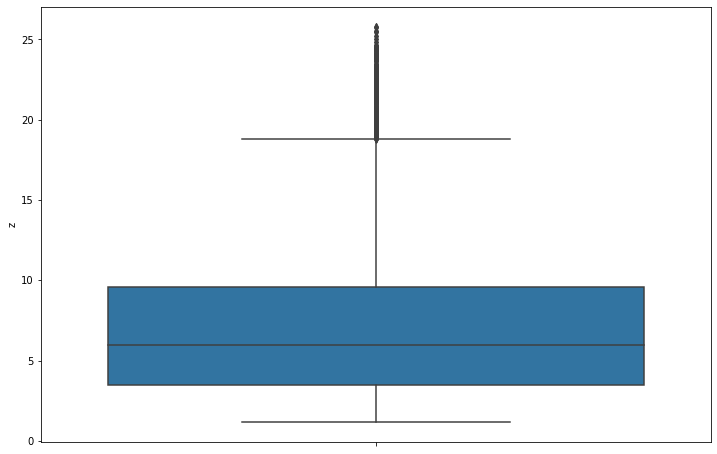

In [448]:
plt.figure(figsize=(12, 8))
sns.boxplot(y=train.z)

<AxesSubplot:ylabel='z'>

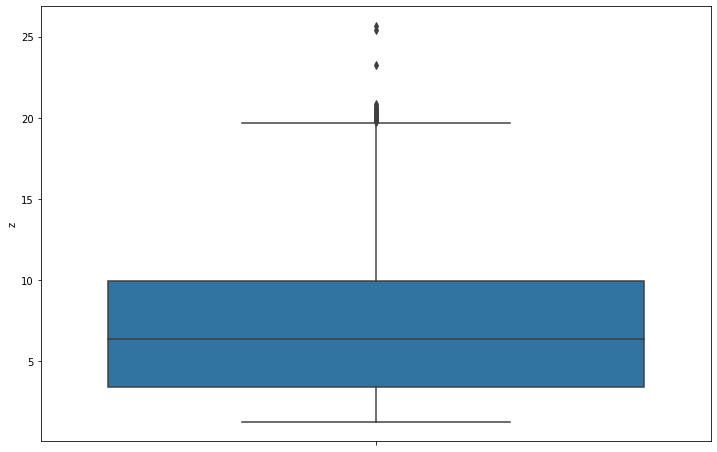

In [449]:
plt.figure(figsize=(12, 8))
sns.boxplot(y=val.z)

In [450]:
train.z.describe()

count    12079.000000
mean         7.104429
std          4.610862
min          1.164255
25%          3.454365
50%          5.990357
75%          9.604016
max         25.792759
Name: z, dtype: float64

In [451]:
val.z.describe()

count    6176.000000
mean        7.175107
std         4.325838
min         1.293171
25%         3.449184
50%         6.404300
75%         9.951014
max        25.646538
Name: z, dtype: float64

<AxesSubplot:ylabel='z'>

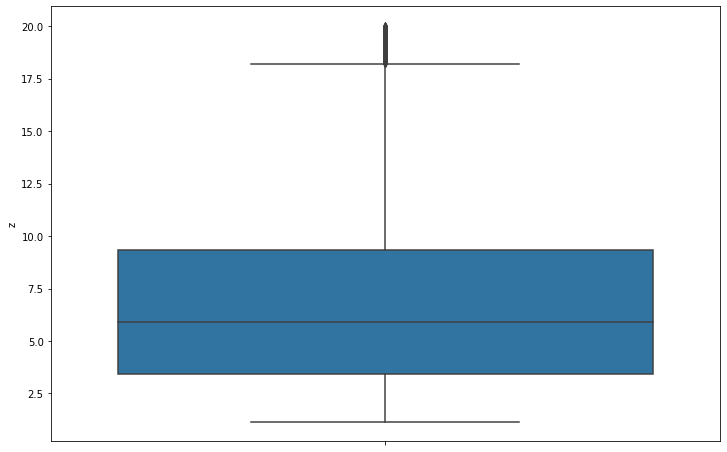

In [453]:
# Remove outliers higher than 20
train = train_df[train_df.z < 20]

plt.figure(figsize=(12, 8))
sns.boxplot(y=train.z)

In [469]:
sns.set_style('darkgrid')

Text(0.5, 1.0, 'Val Data Z distribution')

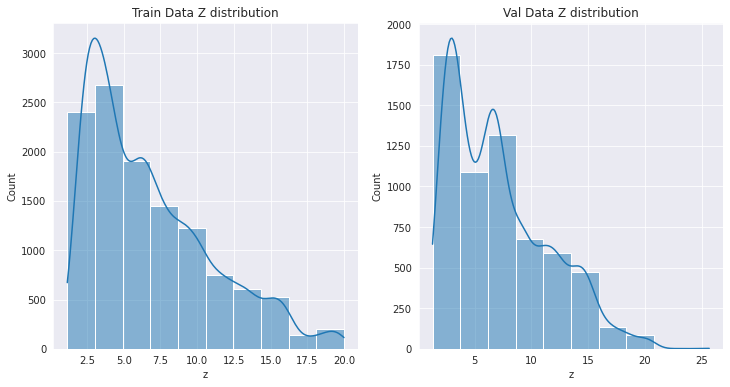

In [483]:
fig, ax = plt.subplots(figsize=(12,6), ncols=2)
sns.histplot(train.z, ax=ax[0], bins=10, kde=True)
sns.histplot(val.z, ax=ax[1], bins=10, kde=True)
ax[0].set_title('Train Data Z distribution')
ax[1].set_title('Val Data Z distribution')

In [ ]:
X_train = train_df.drop(['x', 'y', 'z'], axis=1)
y_train = train_df.z

X_val = val_df.drop(['x', 'y', 'z'], axis=1)
y_val = val_df.z